In [1]:
import MDAnalysis as mda
#from MDAnalysis.tests.datafiles import PSF, DCD, CRD, DCD2, PDB_small
from MDAnalysis.analysis import distances,diffusionmap, align, rms,contacts,dihedrals, encore
from MDAnalysis.analysis.rms import RMSF
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from mpl_toolkits.axisartist.parasite_axes import SubplotHost
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
from itertools import product
import timeit
import time
import math
import os.path
import seaborn as sns
import pandas as pd
import csv
from matplotlib.colors import to_rgb
from matplotlib.collections import PolyCollection
from matplotlib.legend_handler import HandlerTuple
import scipy.signal as sig
from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [2]:
wt_all_chainA=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/wt_chainA/output/wt_chainA_volumes.tabbed.txt')[:,1].tolist()
wt_all_chainB=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/wt_chainB/output/wt_chainB_volumes.tabbed.txt')[:,1].tolist()
wt_all=wt_all_chainA+wt_all_chainB

dm_all_chainA=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/dm_chainA/output/dm_chainA_volumes.tabbed.txt')[:,1].tolist()
dm_all_chainB=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/dm_chainB/output/dm_chainB_volumes.tabbed.txt')[:,1].tolist()
dm_all=dm_all_chainA+dm_all_chainB

delP168_all_chainA=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/delP168_chainA/output/delP168_chainA_volumes.tabbed.txt')[:,1].tolist()
delP168_all_chainB=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/delP168_chainB/output/delP168_chainB_volumes.tabbed.txt')[:,1].tolist()
delP168_all=delP168_all_chainA+delP168_all_chainB

a173v_all_chainA=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/a173v_chainA/output/a173v_chainA_volumes.tabbed.txt')[:,1].tolist()
a173v_all_chainB=np.loadtxt('/net/gpfs-amarolab/fiona/sars-cov-2/protease/dimer/analysis/povme_r10/a173v_chainB/output/a173v_chainB_volumes.tabbed.txt')[:,1].tolist()
a173v_all=a173v_all_chainA+a173v_all_chainB

(array([  8.,  46., 169., 472., 743., 862., 560., 282., 126.,  32.]),
 array([124. , 195.8, 267.6, 339.4, 411.2, 483. , 554.8, 626.6, 698.4,
        770.2, 842. ]),
 <BarContainer object of 10 artists>)

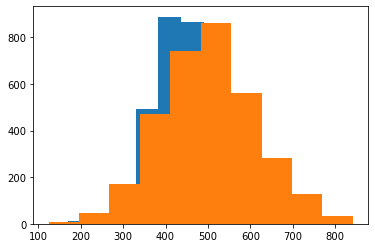

In [5]:
plt.hist(wt_all_chainA)
plt.hist(dm_all_chainA)

In [8]:
def plot_distributions(wt,dm,delP168,a173v,title):
    params = {
        #'font.family': 'sans-serif',
        #'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
        
    collection=wt+dm+delP168+a173v
    start=np.min(collection)-1
    stop=np.max(collection)+1
    
    domain = np.linspace(start,stop,10000)
    
    dens_wt = gaussian_kde(wt)
    dens_wt.covariance_factor = lambda : 0.25
    
    dens_dm = gaussian_kde(dm)
    dens_dm.covariance_factor = lambda : 0.25
    
    dens_delP168 = gaussian_kde(delP168)
    dens_delP168.covariance_factor = lambda : 0.25
    
    dens_a173v = gaussian_kde(a173v)
    dens_a173v.covariance_factor = lambda : 0.25
    
    #fig = plt.figure(figsize=(12,8))
    fig, axs = plt.subplots(1,1, sharex=True, sharey=True, tight_layout=True, figsize=(16,16))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    
    ## plot a_XXX's together
    p1, = axs.plot(domain,dens_wt(domain),'black',alpha=0.8,linewidth=4,label='WT') ## column 2 = interface 1
    axs.fill_between(domain,dens_wt(domain),color='black',alpha=0.2)
    p2, = axs.plot(domain,dens_dm(domain),'blue',alpha=0.8,linewidth=4,label='DM') ## column 2 = interface 1
    axs.fill_between(domain,dens_dm(domain),color='blue',alpha=0.2)
    p3, = axs.plot(domain,dens_delP168(domain),'red',alpha=0.8,linewidth=4,label="$\Delta$P168") ## column 2 = interface 1
    axs.fill_between(domain,dens_delP168(domain),color='red',alpha=0.2)
    p4, = axs.plot(domain,dens_a173v(domain),'g',alpha=0.8,linewidth=4,label='A173V') ## column 2 = interface 1
    axs.fill_between(domain,dens_a173v(domain),color='g',alpha=0.2)
    
    
    #plt.title("Distribution of Active Site Pocket Volume")
    plt.ylabel("Density",labelpad=60)
    plt.xlabel("Active Site Pocket Volumes ($\AA{}^3$)")
    
    
    plt.legend(fontsize=36)
    plt.legend(handles=[p1, p2, p3, p4], fontsize=36)
    fig.tight_layout()
    plt.savefig('{}_activesite_pocket_vols_r10_hist.png'.format(title),bbox_inches='tight',dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


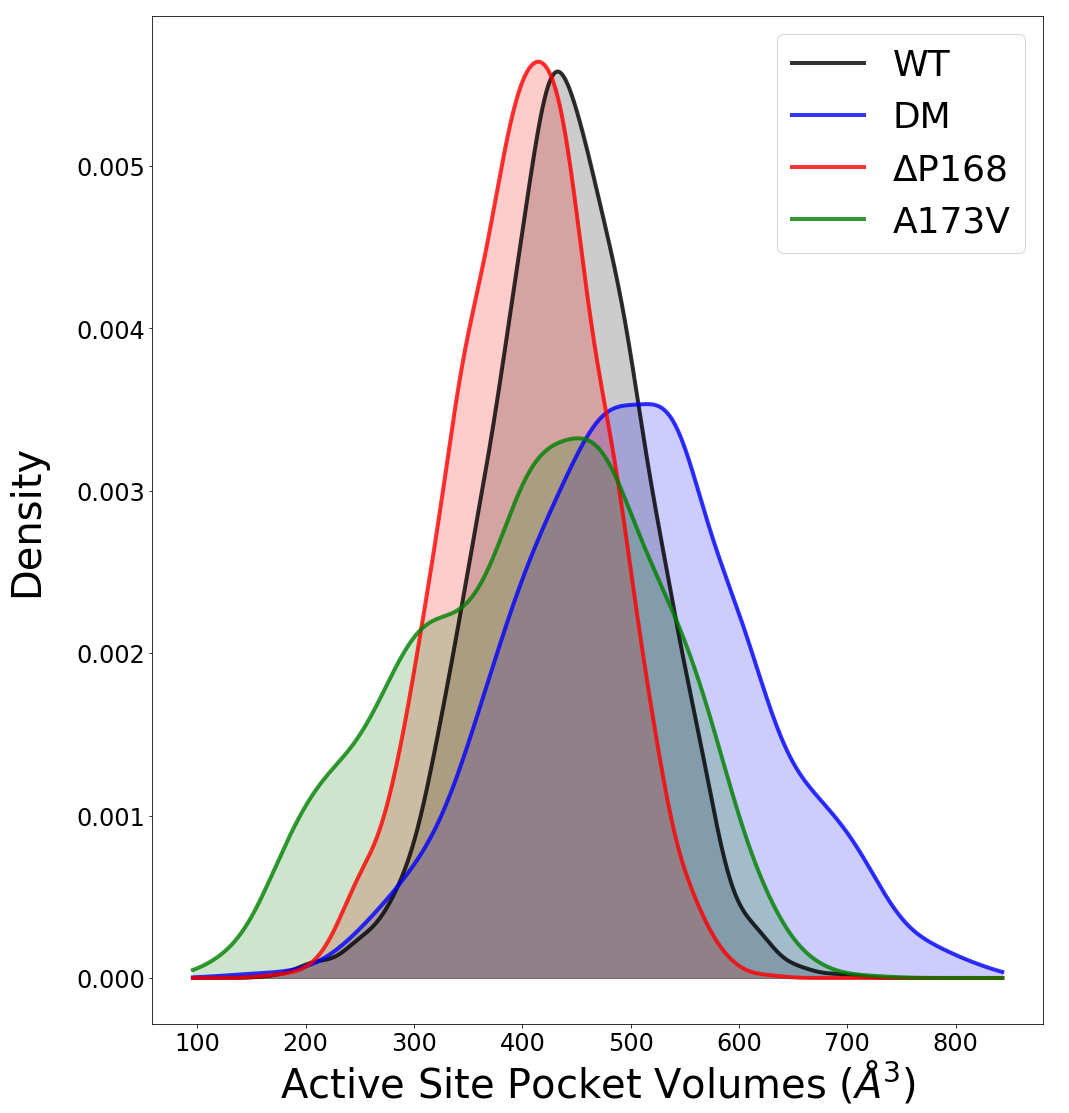

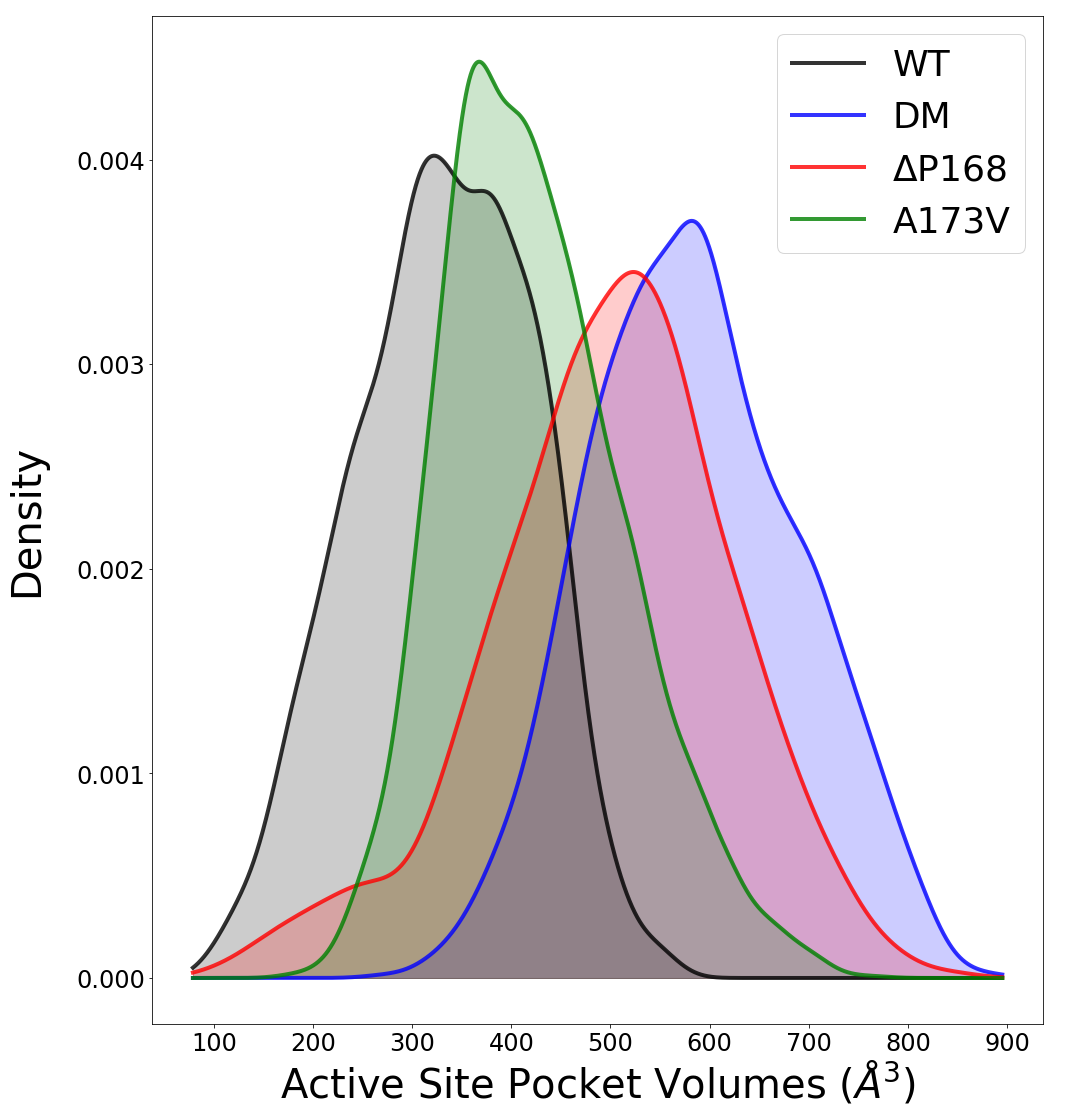

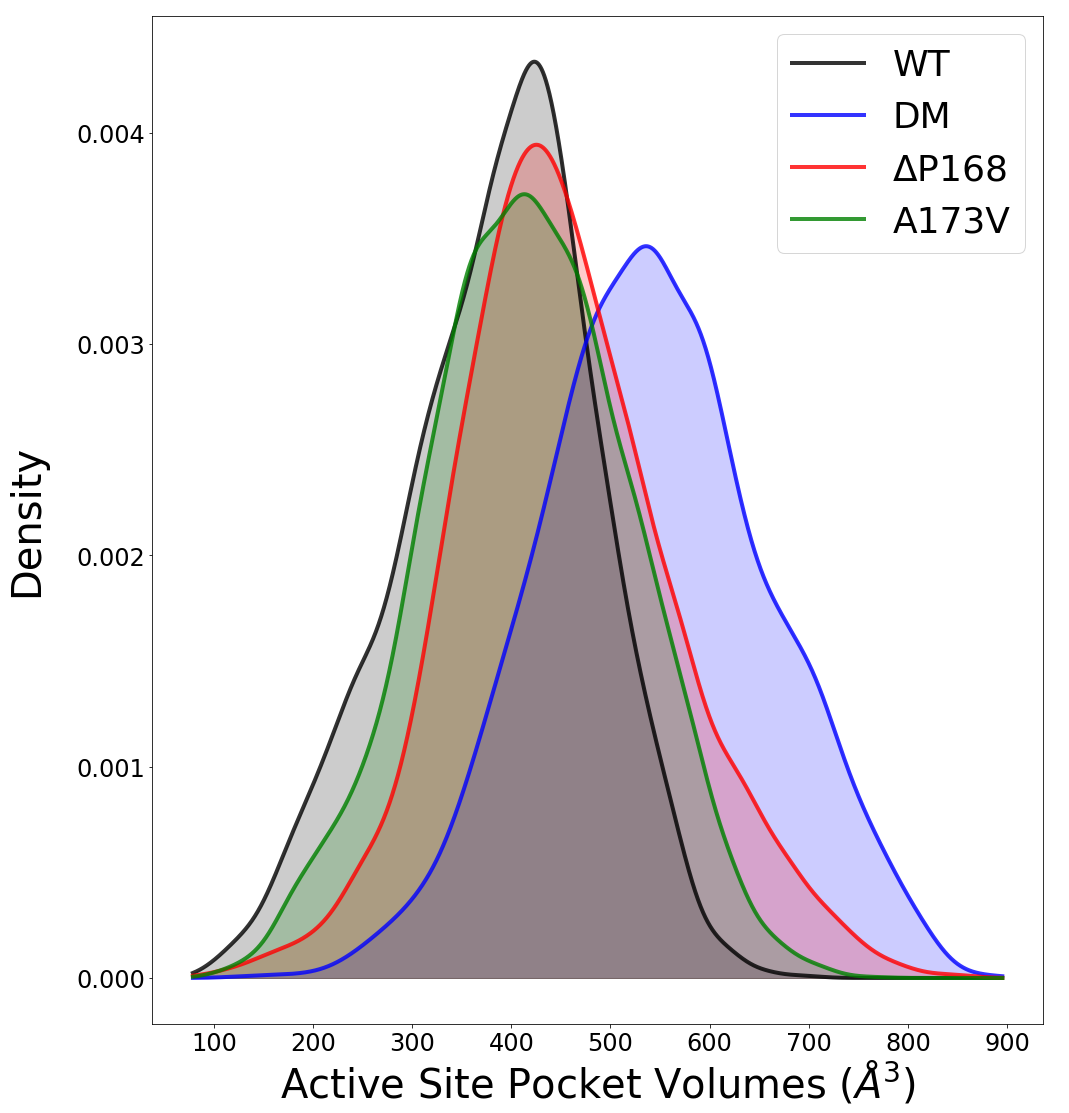

In [9]:
plot_distributions(wt_all_chainA,dm_all_chainA,delP168_all_chainA,a173v_all_chainA,"wt_dm_delP168_a173v_chainA")
plot_distributions(wt_all_chainB,dm_all_chainB,delP168_all_chainB,a173v_all_chainB,"wt_dm_delP168_a173v_chainB")
plot_distributions(wt_all,dm_all,delP168_all,a173v_all,"wt_dm_delP168_a173v_all")

In [11]:
def plot_scatter(wta,wtb,dma,dmb,delP168a,delP168b,a173va,a173vb,title):
    params = {
        #'font.family': 'sans-serif',
        #'font.sans-serif': 'Arial',
         'legend.fontsize': '36',
         #'figure.figsize': (24,12),
         'axes.labelsize': '40',
         'axes.titlesize': '40',
         'xtick.labelsize': '24',
         'ytick.labelsize': '24'
         #'xtick.size': '30'
         #'ytick.size': '30'
    }
    
    pylab.rcParams.update(params)
    
    left,width=0.1,0.65
    bottom,height=0.1,0.65
    spacing=0.005
    
    rect_scatter=[left,bottom,width,height]
    rect_histx=[left,bottom+height+spacing,width,0.2]
    rect_histy=[left+width+spacing,bottom,0.2,width]
    
    fig=plt.figure(figsize=(12,12))
    
    ax=fig.add_axes(rect_scatter)
    ax_histx=fig.add_axes(rect_histx,sharex=ax)
    ax_histy=fig.add_axes(rect_histy,sharey=ax)
    
    ax_histx.tick_params(axis="x",labelbottom=False)
    ax_histy.tick_params(axis="y",labelbottom=False)
    
    ## plot a_XXX's together
    ax.scatter(wta,wtb,color='black',alpha=0.8)
    ax.scatter(dma,dmb,color='blue',alpha=0.8)
    ax.scatter(delP168a,delP168b,color='red',alpha=0.8)
    ax.scatter(a173va,a173vb,color='green',alpha=0.8)
    
    bins_x=np.arange(100,1000,10).tolist()
    bins_y=np.arange(100,1000,10).tolist()
    ax_histx.hist(wta,bins_x,color='k',alpha=0.8)
    ax_histy.hist(wtb,bins_y,orientation='horizontal',color='k',alpha=0.8)
    ax_histx.hist(dma,bins_x,color='b',alpha=0.8)
    ax_histy.hist(dmb,bins_y,orientation='horizontal',color='b',alpha=0.8)
    ax_histx.hist(delP168a,bins_x,color='r',alpha=0.8)
    ax_histy.hist(delP168b,bins_y,orientation='horizontal',color='r',alpha=0.8)
    ax_histx.hist(a173va,bins_x,color='g',alpha=0.8)
    ax_histy.hist(a173vb,bins_y,orientation='horizontal',color='g',alpha=0.8)
    
    ax.set_ylabel("Pocket A ($\AA{}^3$)")
    ax.set_xlabel("Pocket B ($\AA{}^3$)")
    
    plt.savefig('pocket_r10_ab_scatter.png'.format(title),bbox_inches='tight',dpi=300)

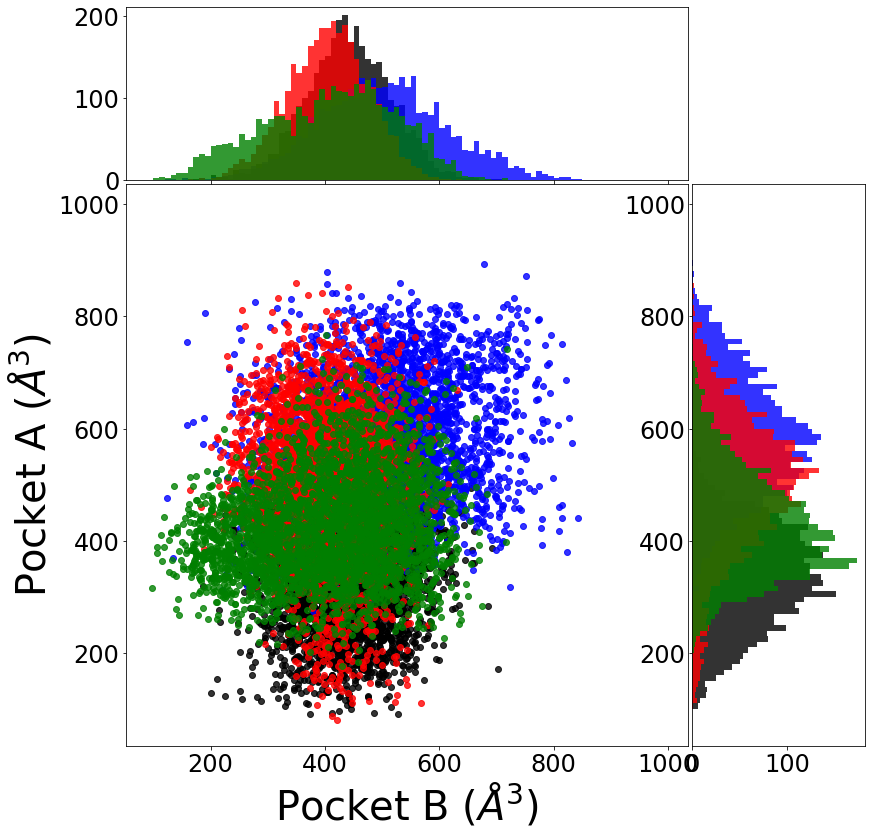

In [12]:
plot_scatter(wt_all_chainA,wt_all_chainB,dm_all_chainA,dm_all_chainB,delP168_all_chainA,delP168_all_chainB,a173v_all_chainA,a173v_all_chainB,"wt_dm_delP168_a173v_all_scatter")